# OSN Graph Exploration
___
This notebook demonstrates a few methods for manipulating and visualizing graphs.

I have taken inspiration from the following notebooks:

[Visualizing Adjacency Matrices in Python](http://sociograph.blogspot.com/2012/11/visualizing-adjacency-matrices-in-python.html)

[Networks with Plotly](https://plot.ly/ipython-notebooks/networks/)


The data we will use is from the [Stanford Large Network Dataset Collection](https://snap.stanford.edu/data/). Specifically, we will use data captured from Facebook.

The particular dataset we will use is nothing more than a list of graph edges. Each line of the data file represents an edge by specifying two nodes that are connected. Note that this is an undirected graph, so an edge from node A to B is the same as an edge from node B to A.
___
### Step 0: Import Libraries
___
For this notebook, we will use a few different python libraries: 

#### [Python Data Analysis Library (Pandas)](http://pandas.pydata.org)
"Pandas is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language."

#### [NetworkX](https://networkx.github.io)
"NetworkX is a Python language software package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks."

#### [SciPy](https://www.scipy.org)
"SciPy is a Python-based ecosystem of open-source software for mathematics, science, and engineering."

#### [matplotlib](http://matplotlib.org)
"matplotlib is a python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms."

#### [Plotly](https://plot.ly)
"Plotly's Python graphing library makes interactive, publication-quality graphs online."
___

Our first step, then, is to import these libraries:

In [75]:
import pandas
import networkx
import scipy
import matplotlib
import plotly.plotly as plt
from plotly.graph_objs import *
%matplotlib inline

### Step 1: Import our data
___

We will use pandas to read the raw OSN data from a text file. The file is a list of edges, with each row containing a source node and a destination node. (Although "source" and "destination" are arbitrary labels in an undirected graph.)

In [76]:
#edges = pandas.read_csv('data/facebook_combined.txt', sep=' ', names=['src', 'dst'])
# Sadly the full Facebook data set is too large for plotly to handle :(

edges = pandas.read_csv('data/facebook/414.edges', sep=' ', names=['src', 'dst'])

# Let's see what the data looks like
edges.head()

,src,dst
0,650,647
1,461,544
2,614,515
3,363,348
4,436,428


### Step 2: Create a Graph and Populate It
___
Now we will use networkx to create a new graph object. Then we will step through our data and add an edge to the graph for each row of the dataframe.

In [77]:
# Create a new graph object
G = networkx.Graph()

# Iterate through edges and add each edge to the graph
for i in range(len(edges.index)):
    G.add_edge(edges.iloc[i,0], edges.iloc[i,1])


We can check our graph object to see how many edges and nodes it contains.

In [78]:
print("Edges:", G.number_of_edges())
print("Nodes:", G.number_of_nodes())

Edges: 1693
Nodes: 150


### Step 3: Visualizing the Graph
___
Our next step is to try to visualize the graph. First, we will use a built-in drawing function provided by networkx, which relies on matplotlib.

By default, this function uses a layout called a "spring layout." With this layout, the positions of the nodes are generated randomly each time we feed the graph object into the function.

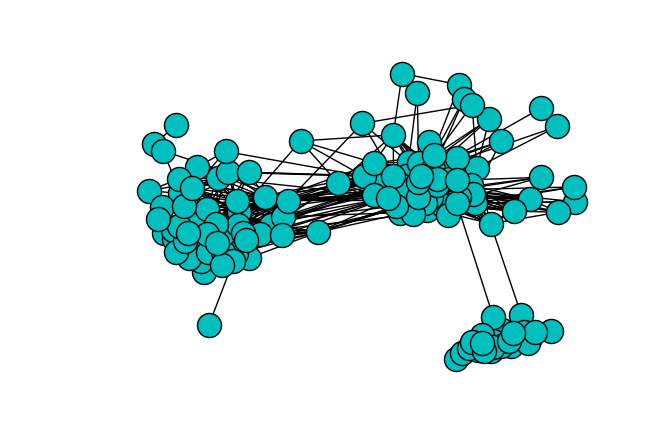

In [79]:
networkx.draw(G, node_color='c', edge_color='k')

Now we can try a different layout. This time we will use a spectral layout, which is deterministic.

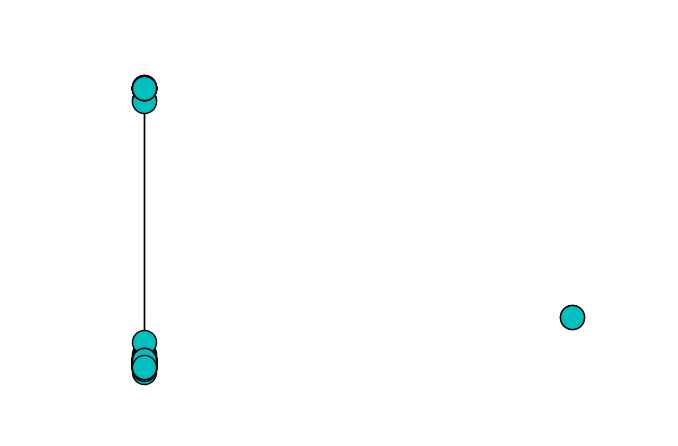

In [80]:
networkx.draw_spectral(G, node_color='c', edge_color='k')

The other thing we can do is to compute the adjacency matrix representation of the graph, and attempt to visualize that as well using matplotlib.

In [81]:
# Compute adjacency matrix of G
mat = networkx.adjacency_matrix(G)

# Compute spectrum of G
spec = networkx.adjacency_spectrum(G)

# Let's look at one of the eigenvalues
spec[0]

(35.514938383318409+0j)

One thing to point out is that since this is an undirected graph, its adjacency matrix will be symmetric about the diagonal. Moreover, the corresponding graph eigenvalues are real, with no imaginary component. 

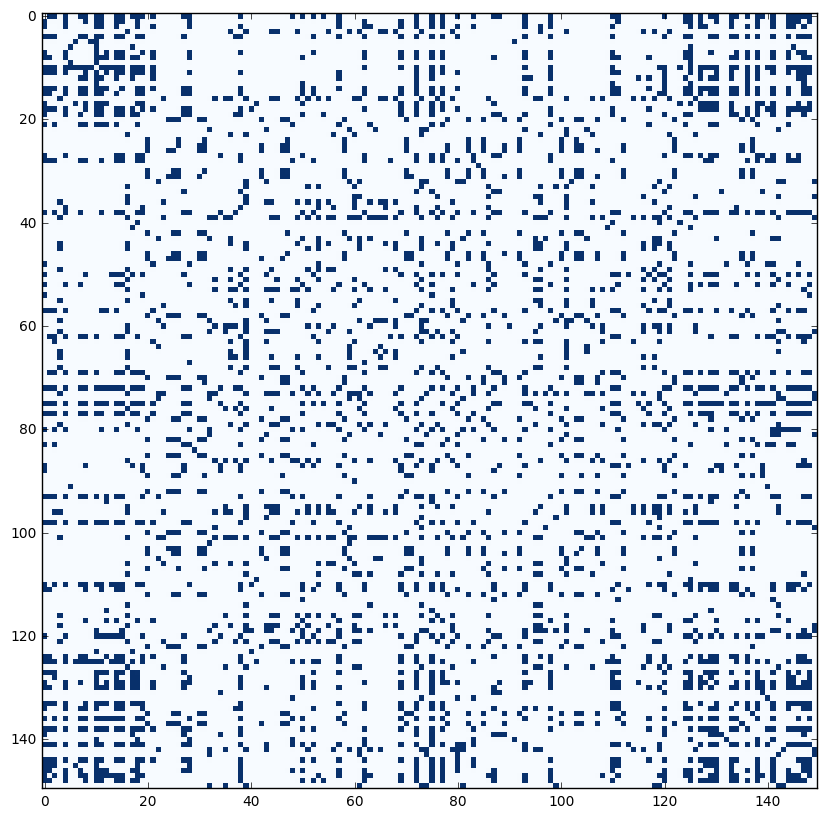

In [82]:
# Change the size of the figure
matplotlib.pyplot.figure(figsize=(10, 10))

# Convert graph data to proper format
adjacency_matrix = networkx.to_numpy_matrix(G)

# Generate plot
matplotlib.pyplot.imshow(adjacency_matrix, cmap="Blues", interpolation="none")

### Step 4: Creating an interactive Graph with plot.ly
___
Next, we will try to create an interactive graph using the plot.ly library. This method is considerably more complex than the built-in draw method that we used previously.

The first thing we must do is to create a data structure that contains the position of each node in the graph. Again, we will use the spring layout.

In [83]:
# Compute node positions
positions = networkx.spring_layout(G)

# Let's see what these look like...
positions

{34: array([ 0.87539611,  0.68344931]),
 107: array([ 0.80064301,  0.46802234]),
 173: array([ 0.92045417,  0.73293258]),
 348: array([ 0.69181503,  0.54137702]),
 363: array([ 0.69931438,  0.44703474]),
 370: array([ 0.59671072,  0.48749365]),
 373: array([ 0.64091657,  0.45980581]),
 374: array([ 0.63311806,  0.54027053]),
 376: array([ 0.69544802,  0.52263691]),
 378: array([ 0.64372049,  0.48568003]),
 391: array([ 0.59791709,  0.52164197]),
 394: array([ 0.68702971,  0.39133422]),
 395: array([ 0.57039208,  0.40094548]),
 400: array([ 0.64940153,  0.44560542]),
 412: array([ 0.60265112,  0.45135547]),
 422: array([ 0.45554054,  0.28083683]),
 423: array([ 0.66893386,  0.54407918]),
 427: array([ 0.80940143,  0.70384843]),
 428: array([ 0.7119618 ,  0.49020133]),
 431: array([ 0.60997314,  0.55215554]),
 434: array([ 0.65759359,  0.59471776]),
 436: array([ 0.64388906,  0.55686073]),
 438: array([ 0.57568411,  0.48722646]),
 461: array([ 0.63016518,  0.39627281]),
 465: array([ 0.6

Next, we must define a couple of functions in order to help us plot these nodes.

The scatter_nodes function will generate a "trace" of the nodes that we can use to build our graph.

In [84]:
def scatter_nodes(pos):
    # Create a trace tuple
    trace = Scatter(x=[], y=[], mode='markers', marker=Marker(size=[]))
    # Step through positions and add each position to the trace
    for p in pos:
        trace['x'].append(pos[p][0])
        trace['y'].append(pos[p][1])
    trace = dict(trace, name='', text=None, hoverinfo='text', opacity=1, marker=dict(size=20))
    return trace

Similarly, the scatter_edges function will generate another "trace", this time of the edges between nodes.

In [85]:
def scatter_edges(G, pos):
    # Create a trace tuple
    trace = Scatter(x=[], y=[], mode='lines', hoverinfo='none', line=dict(width=1))
    # Step through edges and add each one to the trace
    for edge in G.edges():
        trace['x'] += [pos[edge[0]][0], pos[edge[1]][0], None]
        trace['y'] += [pos[edge[0]][1], pos[edge[1]][1], None]
    return trace

Next, we will define some layout parameters:

In [86]:
axis = dict(showline = False, showgrid = False, showticklabels = False, title = '')
layout = Layout(title = 'Facebook Relationships - Spring Layout',
            font = Font(),
            showlegend = False,
            autosize = False,
            width = 1000,
            height = 1000,
            xaxis = XAxis(axis),
            yaxis = YAxis(axis),
            margin = Margin(l = 40, r = 40, b = 85, t = 100, pad = 0),
            hovermode='closest',
            plot_bgcolor='#EFECEA')

Finally, we will use our functions to generate the edge and node traces, which we will then plot using plotly:

In [87]:
# Compute edge trace
G_edges = scatter_edges(G, positions)

# Compute node trace
G_nodes = scatter_nodes(positions)

# Plot with plot.ly
plt.iplot(Figure(data = Data([G_edges, G_nodes]), layout = layout))